# Notebook \#2 - Implementation of Fourier Neural Operator

In this beginning notebook, I am going to construct a framework for learning neural operators using the Fourier Neural Operator (FNO) architecture and solve a Diffusion Problem (to be explained later). The structure of this notebook goes as follows:
- Implement a class for the FNO architecture
- Implement a function for training the FNO with given differential equations and initial/boundary conditions
- Generate a training dataset for the input control functions and the corresponding analytical solutions of the differential equation
- Define loss functions associated with physics loss, initial, and boundary conditions
- Train the FNO
- Solve the Feldbaum Problem

Let's start by implementing the Fourier Neural Operator architecture.


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.fft import fft, ifft
import numpy as np
from datetime import datetime
from data import MultiFunctionDatasetODE, custom_collate_ODE_fn 
import plotter  

## Key Components of the FNO Architecture

### 1. Input Lifting with an MLP

- **Purpose:**  
  The first step is to "lift" the input data—typically low-dimensional features (e.g., time `t` and a function `u`)—into a higher-dimensional feature space. This is done using a Multi-Layer Perceptron (MLP).

- **Implementation:**  
  An MLP is built using a list of layer sizes (e.g., `[2, n_hid, n_hid]`) and corresponding activation functions (e.g., `['tanh', 'tanh']`). This network transforms the concatenated input `(t, u)` into a lifted representation suitable for spectral processing.

---

### 2. Spectral Convolution with Fourier Layers

- **Fourier Transform:**  
  The FNO converts the lifted input into the frequency domain using the Fast Fourier Transform (FFT). For example, in the code:

```python
  x_ft = fft(x, dim=-1)
```
#### Learnable Spectral Filtering:
In the frequency domain, a subset of the Fourier modes (specifically the lower modes, which capture the most significant features) is filtered using learnable weights. This is achieved via an efficient tensor contraction with torch.einsum:
out_ft[:, :, :self.modes] = torch.einsum("bcm,cio->bio", x_ft[:, :, :self.modes], self.weights)
Here:
```python
x_ft[:, :, :self.modes] represents the selected Fourier modes.
```
`self.weights` are learnable parameters with shape `(in_channels, out_channels, modes)`.
#### Inverse Fourier Transform:
After applying the spectral filter, the data is transformed back to the spatial domain using the inverse FFT:
```python
x_out = ifft(out_ft, dim=-1)
return x_out.real
```
Only the real part of the inverse transform is used.
#### Stacking Layers:
Multiple Fourier layers can be stacked to enhance the model’s capacity. An optional nonlinearity (such as tanh) can be applied after each Fourier layer.

### 3. Output Projection with an MLP
***Purpose:***
After spectral convolution, the data is still in a high-dimensional space. An output MLP projects this representation back to the desired output dimension (typically a scalar per input point).
***Implementation:***
Similar to the input MLP, the output MLP is built using a list of layer sizes (e.g., `[n_hid, n_hid, 1]`) and corresponding activation functions (e.g., `['tanh', None]`).


In [137]:
class FourierLayer(nn.Module):
    def __init__(self, width, modes):
        super(FourierLayer, self).__init__()
        self.modes = modes
        self.weights = nn.Parameter(
            torch.randn(width, width, modes, dtype=torch.cfloat) * (1 / width)
        )
        self.local_transform = nn.Conv1d(width, width, kernel_size=1)

    def forward(self, x):
        B, C, N = x.shape
        x_ft = fft(x, dim=-1, norm='ortho')

        out_ft = torch.zeros(B, C, N, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes] = torch.einsum("bcm,cdm->bdm", x_ft[:, :, :self.modes], self.weights)

        x_global = ifft(out_ft, dim=-1, norm='ortho').real
        x_local = self.local_transform(x)

        return x_global + x_local

class FNO(nn.Module):
    def __init__(self, modes=16, width=64, depth=4, input_channels=2, output_channels=1, hidden_size=128):
        super(FNO, self).__init__()
        self.width = width

        # Input lifting from 2 input features (x and t) to higher-dimensional space
        self.input_proj = nn.Linear(input_channels, width)

        # Stack Fourier layers with normalization and residual connections
        self.layers = nn.ModuleList([
            FourierLayer(width, modes) for _ in range(depth)
        ])
        self.norms = nn.ModuleList([
            nn.BatchNorm1d(width) for _ in range(depth)
        ])

        # Output projection back to single dimension
        self.output_proj = nn.Sequential(
            nn.Linear(width, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_channels)
        )

        self.activation = nn.ReLU()

    def forward(self, x, t):
        # x, t: [B, N]
        input_tensor = torch.stack([x, t], dim=-1)  # [B, N, 2]
        x = self.input_proj(input_tensor)  # [B, N, width]
        x = x.permute(0, 2, 1)  # [B, width, N]

        for layer, norm in zip(self.layers, self.norms):
            residual = x
            x = layer(x)
            x = self.activation(norm(x))
            x = x + residual

        x = x.permute(0, 2, 1)  # [B, N, width]
        x = self.output_proj(x)  # [B, N, 1]

        return x.squeeze(-1)  # [B, N]

In [142]:
def compute_loss(model, u, t, dim_x=1):
    """
    Compute loss for solving the PDE: dx/dt - x + u = 0
    using physics-informed residuals and initial condition.

    Args:
        model: the FNO model
        u: torch.Tensor of shape [B, N], control input
        t: torch.Tensor of shape [B, N], time values (requires grad)
        dim_x: not used here, placeholder if you plan to expand to higher dimensions
    Returns:
        physics_loss: mean squared residual of the PDE
        initial_loss: MSE loss enforcing x(t=0) = 1
    """
    t.requires_grad_(True)

    # Predict solution
    x = model(u, t)  # [B, N]

    # Compute dx/dt using automatic differentiation
    dx_dt = torch.autograd.grad(
        outputs=x,
        inputs=t,
        grad_outputs=torch.ones_like(x),
        create_graph=True,
        retain_graph=True
    )[0]

    # Physics loss: residual of the PDE
    residual = dx_dt - x + u
    physics_loss = torch.mean(residual ** 2)

    # Enforce initial condition: x(t=0) = 1
    t0 = torch.zeros_like(t)
    x0 = model(u, t0)
    initial_loss = torch.mean((x0 - 1) ** 2)

    return physics_loss, initial_loss


In [155]:
def train(model, dataloader, optimizer, num_epochs=1000):
    """
    Trains the model on the given dataset.
    Additional logging and model saving is done every few epochs.
    """
    
    for epoch in range(num_epochs):
        model.train()
        # Iterate over batches
        for u, t, _, _ in dataloader:

            t = t.T.repeat(u.shape[0], 1)          
            physics_loss, initial_loss = compute_loss(model, u, t)
            loss = physics_loss + initial_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, '
                f'physics_loss: {physics_loss.item():.6f}, '
                f'initial_loss: {initial_loss.item():.6f}, '
                f'time: {datetime.now().time()}')
        
        # Save model every 10 epochs
        if (epoch + 1) % 10 == 0:
            timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')
            model_filename = f'epochs_[{epoch}]_model_time_[{timestamp}]_loss_[{loss.item():.4f}].pth'
            torch.save(model.state_dict(), f"trained_models/fno/{model_filename}") 


In [156]:
# Initialize the model and move it to GPU.
model = FNO(modes=16, width=64, depth=4)

#Dataset parameters
n_functions = 10000
grf_lb = 0.02
grf_ub = 0.5
end_time = 1.0
num_domain = 200
num_initial = 20
batch_size = 128
m = 200

dataset = MultiFunctionDatasetODE(
    m=m,
    n_functions=n_functions,
    function_types=['grf', 'linear', 'sine', 'polynomial','constant'],
    end_time = end_time,
    num_domain = num_domain,
    num_initial = num_initial,
    grf_lb = grf_lb,
    grf_ub = grf_ub
)

dataloader = DataLoader(dataset, batch_size=128, collate_fn=custom_collate_ODE_fn, shuffle=True)


In [152]:

# Training hyperparameters
epochs = 10
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)


# Start training with optional plotting enabled.
train(model, dataloader, optimizer, epochs)

Epoch [1/1], Loss: 1.5612, physics_loss: 0.794303, initial_loss: 0.766891, time: 15:54:25.044414
Epoch [1/1], Loss: 1.3946, physics_loss: 0.781949, initial_loss: 0.612659, time: 15:54:25.861253
Epoch [1/1], Loss: 1.2916, physics_loss: 0.660892, initial_loss: 0.630664, time: 15:54:26.680333
Epoch [1/1], Loss: 1.2120, physics_loss: 0.743030, initial_loss: 0.468990, time: 15:54:27.512735
Epoch [1/1], Loss: 0.8486, physics_loss: 0.452076, initial_loss: 0.396497, time: 15:54:28.333224
Epoch [1/1], Loss: 0.9199, physics_loss: 0.587860, initial_loss: 0.332076, time: 15:54:29.150467
Epoch [1/1], Loss: 0.7332, physics_loss: 0.416522, initial_loss: 0.316710, time: 15:54:29.977554
Epoch [1/1], Loss: 0.7186, physics_loss: 0.424028, initial_loss: 0.294543, time: 15:54:30.793424
Epoch [1/1], Loss: 0.8626, physics_loss: 0.595267, initial_loss: 0.267304, time: 15:54:31.614189
Epoch [1/1], Loss: 0.6088, physics_loss: 0.373390, initial_loss: 0.235403, time: 15:54:32.528048
Epoch [1/1], Loss: 0.9680, phy

In [153]:
def objective_function(n, args):
    """
    Compute the objective:
      J(u) = 0.5 * ∫₀¹ (x² + u²) dt + penalty terms,
    enforcing:
      dx/dt - (x - u) = 0  and  x(0) = 1.
    
    Args:
        n (int): Batch size.
        args (dict): Contains:
            'x': Predicted state tensor of shape (n, m),
            'u': Control tensor of shape (n, m),
            't': Time tensor of shape (n, m).
    
    Returns:
        J (Tensor): The total objective (scalar).
    """
    # Assuming the state x is scalar so dim_x = 1.
    dim_x = 1
    m = args['t'].shape[1]
    dx = torch.zeros(n, m, dim_x, device=args['t'].device)
    
    # Compute time derivative for each batch element.
    for b in range(n):
        grad_val = torch.autograd.grad(
            args['x'][b],
            args['t'][b],
            torch.ones_like(args['x'][b]),
            create_graph=True,
            allow_unused=True  # allow unused gradients
        )[0]
        # Substitute with zeros if grad_val is None.
        if grad_val is None:
            grad_val = torch.zeros_like(args['t'][b])
        # Unsqueeze to make shape (m, 1) so it can be assigned to dx[b] which is (m, 1)
        dx[b] = grad_val.unsqueeze(-1)
    
    # Squeeze to shape (n, m)
    dx_dt = dx[:, :, 0]

    # Physics residual: dx/dt - (x - u) should be 0.
    physics = dx_dt - args['x'] + args['u']
    physics_loss = torch.mean(physics**2)
    
    # Initial condition penalty: x(0) should equal 1.
    initial_loss = torch.mean((args['x'][:, 0] - torch.ones(n, device=args['t'].device))**2)

    # Cost functional: 0.5 * ∫₀¹ (x² + u²) dt computed via the trapezoidal rule.
    cost_integral = torch.trapz((args['x']**2 + args['u']**2).squeeze(), args['t'].squeeze(), dim=-1)
    cost = 0.5 * torch.mean(cost_integral)

    # Total objective: cost + weighted penalty terms.
    J = cost + 100 * physics_loss + 10 * initial_loss
    return J

# ------------------------
# Gradient Descent Routine (Batched Version)
# ------------------------
def gradient_descent(n, alpha, m, num_epochs, model, objective_function):
    """
    Minimizes the objective with respect to the control u.
    
    Args:
        n (int): Batch size.
        alpha (float): Learning rate.
        m (int): Number of time points (sensors).
        num_epochs (int): Number of training epochs.
        model (nn.Module): Your trained FNO model that computes x = model(t, u).
        objective_function (function): Computes the cost given u, t, and model output.
        
    Returns:
        u_opt (Tensor): Optimized control averaged over the batch (shape: [m]).
    """
    # Initialize control u with shape (n, m)
    u = torch.zeros(n, m, device=device)
    
    # Create time grid of shape (n, m) by repeating the same 1D time vector
    t = torch.linspace(0, end_time, m, device=device).unsqueeze(0).repeat(n, 1)
    
    u.requires_grad_(True)
    t.requires_grad_(True)  # if you need gradients for t
    
    optimizer = torch.optim.Adam([u], lr=alpha)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        x = model(t, u)  # FNO model returns x with shape (n, m)
        args = {'x': x, 'u': u, 't': t}
        loss = objective_function(n, args)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 ==0:
        
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, time: {datetime.now().time()}')

    # Return the optimized control averaged over the batch (shape: (m,))
    return torch.mean(u, axis=0)

# ------------------------
# Hyperparameters and Model Loading
# ------------------------
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n = 1      # Batch size (number of random functions)
m = 200       # Number of time points (sensors)
num_epochs = 10000
alpha = 0.001

# (Assume your FNO model class definition is available)
# Instantiate and load your trained FNO model.
#trained_model = FNO(input_net, fourier_layers_config, output_net,
                    #, output_activations, fourier_activation)
#trained_model.to(device)
#trained_model.load_state_dict(torch.load('trained_models/fno/epochs_[29]_model_time_[20250317-233106]_loss_[0.0022].pth', map_location=device))
#trained_model.eval()

# ------------------------
# Run Gradient Descent to Optimize u
# ------------------------
u_opt = gradient_descent(n, alpha, m, num_epochs, model, objective_function)
print("Optimized control u(t):", u_opt)


Epoch [100/10000], Loss: 71.4325, time: 15:55:44.704501
Epoch [200/10000], Loss: 65.8912, time: 15:55:45.322718
Epoch [300/10000], Loss: 60.8663, time: 15:55:45.961895
Epoch [400/10000], Loss: 60.5528, time: 15:55:46.480256
Epoch [500/10000], Loss: 60.2950, time: 15:55:47.103514
Epoch [600/10000], Loss: 60.0227, time: 15:55:47.649384
Epoch [700/10000], Loss: 59.7263, time: 15:55:48.154474
Epoch [800/10000], Loss: 59.4002, time: 15:55:48.618649
Epoch [900/10000], Loss: 59.0790, time: 15:55:49.100536
Epoch [1000/10000], Loss: 58.7358, time: 15:55:49.563839
Epoch [1100/10000], Loss: 58.3818, time: 15:55:50.039460
Epoch [1200/10000], Loss: 58.0105, time: 15:55:50.501611
Epoch [1300/10000], Loss: 57.6194, time: 15:55:51.006400
Epoch [1400/10000], Loss: 57.2282, time: 15:55:51.525968
Epoch [1500/10000], Loss: 56.8204, time: 15:55:52.001243
Epoch [1600/10000], Loss: 56.4086, time: 15:55:52.456549
Epoch [1700/10000], Loss: 55.9918, time: 15:55:52.915324
Epoch [1800/10000], Loss: 55.5594, time:

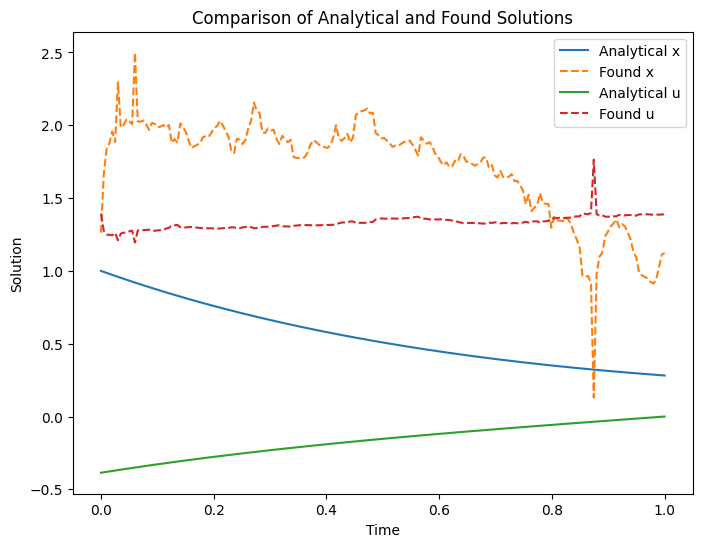

In [154]:
import numpy as np
import matplotlib.pyplot as plt

# Define analytical solutions using NumPy (if not defined yet)
def analytical_x(t):
    numerator = np.sqrt(2) * np.cosh(np.sqrt(2) * (t - 1)) - np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

def analytical_u(t):
    numerator = np.sinh(np.sqrt(2) * (t - 1))
    denominator = np.sqrt(2) * np.cosh(np.sqrt(2)) + np.sinh(np.sqrt(2))
    return numerator / denominator

# Create a time grid for plotting. Here t_plot is a NumPy array of shape (m,)
t_plot = np.linspace(0, end_time, m)

# Compute analytical solutions.
analytical_x_vals = analytical_x(t_plot)
analytical_u_vals = analytical_u(t_plot)

# Prepare inputs for the FNO model.
# u_opt is assumed to be the optimized control (1D tensor of shape (m,))
# We create a time tensor of shape (1, m) and a control tensor of shape (1, m)
t_tensor = torch.linspace(0, end_time, m).unsqueeze(0)
u_tensor = u_opt.unsqueeze(0)

# Get the FNO model output.
x_found = model(t_tensor, u_tensor)  # Expected shape: (1, m)
x_found = x_found.cpu().detach().numpy().flatten()  # Flatten to shape (m,)
u_found = u_opt.cpu().detach().numpy()  # Already shape (m,)

# Plot the results.
plt.figure(figsize=(8, 6))
plt.plot(t_plot, analytical_x_vals, label="Analytical x")
plt.plot(t_plot, x_found, label="Found x", linestyle='--')
plt.plot(t_plot, analytical_u_vals, label="Analytical u")
plt.plot(t_plot, u_found, label="Found u", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Solution")
plt.legend()
plt.title("Comparison of Analytical and Found Solutions")
plt.show()
